In [7]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt

In [315]:
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p =  kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 1000 / koff
k_beta = koff 

p_scaled = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

print(Kd_scaled, kmax_scaled, kbasal_scaled)

0.478375 0.04203519639903277 8.080360096723108e-05


In [316]:

def khammash_ode_scaled(t,x,p_scaled,I):
    if callable(I):
        I = I(t)

    # Parameters
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = p_scaled

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])

    # k_alpha = kon / koff
    # k_beta = koff

    dTFondt = (I * k_alpha * (1 - TFon) - TFon) * k_beta
    # dTFondt = I * kon * (1 - TFon) - koff * TFon
    dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA

    return [dTFondt, dmRNAdt]


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - (TFon  * TFtot)) - koff * (TFon  * TFtot)
    dmRNAdt = kbasal + kmax * ((TFon  * TFtot) ** n) / ((Kd ** n) + ((TFon  * TFtot) ** n)) - kdegR * mRNA

    dTFondt = dTFondt / TFtot
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,-1] - x[:])
    return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def fsolve_func_scaled(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    return (sol.y[:,-1] - x[:])
    # return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    # try:
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
    # except:
    #     print('first one failed')
    #     x_guess = [u,u]
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
    # steady = sol


    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)
    if not sol.success:
        x_guess = [u,u]
        sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)

    steady = np.maximum(sol.x,[0,0])
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=steady, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    steady = np.trapz(sol.y, x=sol.t) / period

    return steady#, sol.success, sol.message, sol.fun

def opto_growth(t,x,p,od_sp=None):

    # Parameters
    kdegR, ktrans_Rep, ktrans_Amp, ktrans_PDC, kdegP_Rep, kdegP_Amp, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp = p

    x_guess = x
    global setpoint
    # if setpoint is None:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess)
    # else:
    #     out = setpoint
    # if ier != 1:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess=None)

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x
    # mRNA_blind = 1

    

    mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S)
    mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S)

    dmRNA_invert_dt = (setpoint[1] - mRNA_invert) / tau_mRNA
    dmRNA_amp_dt = (setpoint[1] - mRNA_amp) / tau_mRNA

    # Enz_opto = Enz_opto / ((mu_max_opto + kdegP) / ktrans)
    ktrans_scaled_invert = ktrans_Rep  # * ((mu_max_invert + kdegP_Rep) / ktrans_Rep)
    ktrans_scaled_PDC_invert = ktrans_PDC  * ((mu_max_invert + kdegPPDC) / ktrans)
    
    dRepdt = ktrans_scaled_invert * mRNA_invert * S / (Ks + S) - (kdegP_Rep + mu_x_invert) * Rep
    dEnz_invert_dt = ktrans_scaled_PDC_invert * (K_Rep ** n_Rep / (K_Rep ** n_Rep + Rep ** n_Rep)) * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert
    # dEnz_optodt = dEnz_optodt * ((mu_max_opto + kdegP) / ktrans)

    # Enz_blind = Enz_blind / ((mu_max_blind + kdegP) / ktrans)
    ktrans_scaled_amp = ktrans_Amp  # * ((mu_max_amp + kdegP_Amp) / ktrans_Amp)
    ktrans_scaled_PDC_amp = ktrans_PDC  * ((mu_max_amp + kdegPPDC) / ktrans)
    
    dAmpdt = ktrans_scaled_amp * mRNA_amp * S / (Ks + S) - (kdegP_Amp + mu_x_amp) * Amp
    dEnz_amp_optodt = ktrans_scaled_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp
    # dEnz_blind_optodt = dEnz_blind_optodt * ((mu_max_blind + kdegP) / ktrans)

    S0 = 20
    if od_sp is None:
        d = 0
    else:
        d = (mu_x_invert * X_invert + mu_x_amp * X_amp) / (X_invert + X_amp)
        if (X_invert + X_amp) < od_sp:
            d = 0
        elif (X_invert + X_amp) > od_sp:
            d = d #* (X_invert + X_amp)/od_sp
    
    # if setpoint[1] > 0.5:
    #     print(d)
    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp + d * (S0 - S)
    dX_invert_dt = mu_x_invert * X_invert - d * X_invert
    dX_amp_dt = mu_x_amp * X_amp - d * X_amp



    return [dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dX_invert_dt, dX_amp_dt]


In [317]:
kdegR = 0.042116
ktrans_PDC = 1.4514
ktrans_Rep = 1.4514
kdegP = 0.00
K_Rep = 0.01
K_Amp = 0.99

mu_max_invert = 0.0233 / 20
mu_max_amp = 0.014 / 20

# mu_max = mu_max_opto
Ks = 1
Y = 0.5

In [318]:
u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))

In [319]:
from tqdm import tqdm

u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))

# u_arr = np.flip(10 ** np.linspace(-1,0,100))
Enz_arr = np.zeros(u_arr.size)
mRNA_arr = np.zeros(u_arr.size)

setpoint = None
for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
    # print(u)
    period = 100 / 60
    Imax = 1
    setpoint = steady_mRNA_solve(u, period, Imax, x_guess=setpoint)
    # print(setpoint)
    mRNAss = setpoint[1]
    mRNA_arr[i] = mRNAss


100%|██████████| 21/21 [00:45<00:00,  2.15s/it]


In [383]:
K_Rep = 0.15
n_Rep = 2
mu_max_invert = 0.45 / 60

K_Amp = 0.01
mu_max_amp = 0.45 / 60
n_Amp = 1.3

kdegP_Amp = 0.01
kdegP_Rep = 0.005

kdegR = 0.042116

ktrans_PDC = 1.4514
ktrans_Rep = 1.4514 / 7
ktrans_Amp = 1.4514 / 7

ktrans_Rep = ktrans_Rep  * ((mu_max_invert + kdegP_Rep) / ktrans_Rep)  / 1
ktrans_Amp = ktrans_Amp  * ((mu_max_amp + kdegP_Amp) / ktrans_Amp) / 10


kdegPPDC = 0.002
Ks = 20

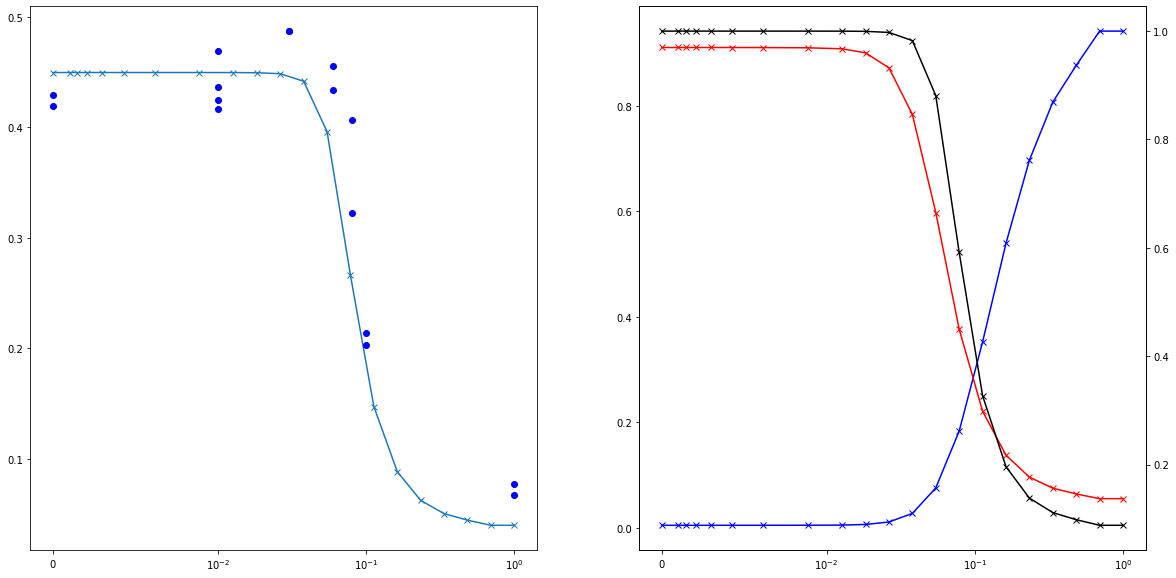

In [384]:
# Inverted Circuit

u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))

# kdegR = 0.042116
# ktrans_PDC = 1.4514
# ktrans_Rep = 1.4514 / 7 
# kdegP_Rep = 0.005
# kdegPPDC = 0.0001
# K_Rep = 0.15
# n_Rep = 2
# mu_max_invert = 0.45 / 60

import matplotlib.pyplot as plt

# ktrans_scaled_invert = ktrans_Rep  * ((mu_max_invert + kdegP_Rep) / ktrans_Rep)   
ktrans_scaled_PDC_invert = ktrans_PDC  * ((mu_max_invert + kdegPPDC) / ktrans_PDC)

ss_Rep = - (1 / (2 * mu_max_invert)) * (kdegP_Rep - np.sqrt(4 * mRNA_arr * mu_max_invert * ktrans_Rep + kdegP_Rep ** 2))

# ss_Rep = mRNA_arr
# ktrans_scaled_invert = ktrans  * ((mu_max_invert + kdegP) / ktrans)
# dEnz_invert_dt = ktrans_scaled_invert * (K_Rep / (K_Rep + Rep)) * S / (Ks + S) - (kdegP + mu_x_invert) * Enz_invert
ss_Enz = - (1 / (2 * mu_max_invert)) * (kdegPPDC - np.sqrt(4 * (K_Rep ** n_Rep / (K_Rep ** n_Rep + ss_Rep ** n_Rep)) \
    * mu_max_invert * ktrans_scaled_PDC_invert + kdegPPDC ** 2))

S = 20 - 2 * Y

mu_arr_invert = ss_Enz * mu_max_invert * 60 # * S / (Ks + S) 

# Real Data
mu_SGy104_1 = np.array([0.429016493, 0.419454997, 0.425278485, 0.468815929, 0.214066814, 0.202848859, 0.077447387, 0.067285511, 0.487083379, 0.487241995,
0.436233624, 0.416734105, 0.433773399, 0.4552301, 0.406627518, 0.322757789])
mu_SGy104_1_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_invert, '-x', label='mu')
ax.plot(mu_SGy104_1_lights, mu_SGy104_1, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, ss_Rep, '-bx', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax2 = ax.twinx()
ax2.plot(u_arr, (K_Rep / (K_Rep + ss_Rep)), '-rx', label='mu')
ax2.plot(u_arr, ss_Enz, '-kx', label='mu')


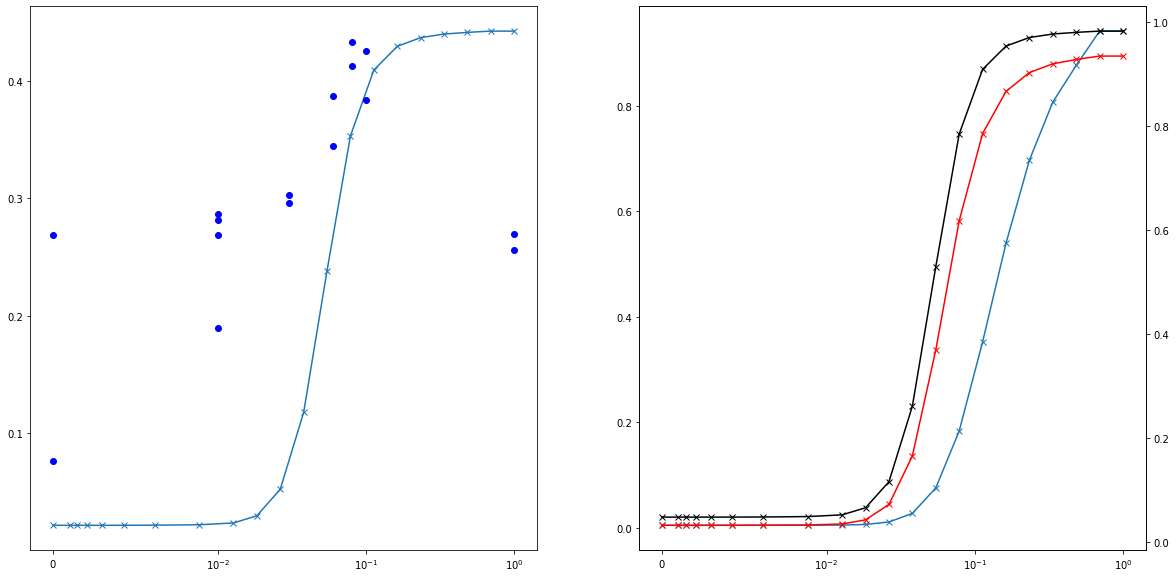

In [385]:
# Amp Circuit
# K_Amp = 0.1
# mu_max_amp = 0.43 / 60
# n_Amp = 4
# ktrans_Amp = 1.4514 
# kdegP_Amp = 0.00001
# kdegPPDC = 0.00

import matplotlib.pyplot as plt

# ktrans_scaled_amp = ktrans_Amp  * ((mu_max_amp + kdegP_Amp) / ktrans_Amp)
ktrans_scaled_PDC_amp = ktrans_PDC  * ((mu_max_amp + kdegPPDC) / ktrans_PDC)

ss_Amp = - (1 / (2 * mu_max_amp)) * (kdegP_Amp - np.sqrt(4 * (mRNA_arr * mu_max_amp * ktrans_Amp) + kdegP_Amp ** 2))
ss_Enz = - (1 / (2 * mu_max_amp)) * (kdegPPDC - np.sqrt(4 * (ss_Amp ** n_Amp / (K_Amp ** n_Amp + ss_Amp ** n_Amp)) * mu_max_amp * ktrans_scaled_PDC_amp + kdegPPDC ** 2))

mu_arr_amp = ss_Enz * mu_max_amp *60

# Real Data
mu_SGy128_4 = np.array([0.07654071, 0.26858448, 0.28688688, 0.19000113, 0.3834206 ,
       0.42503585, 0.25622547, 0.26932193, 0.30298274, 0.29615459,
       0.28158447, 0.26857221, 0.34449419, 0.38737338, 0.412247  ,
       0.43290314])
mu_SGy128_4_lags = np.array([ 0.        , 39.88279932, 19.98011315, 14.4137813 ,  0.        ,
        2.18260617,  0.        ,  1.21280087, 10.40812555,  7.77763666,
       21.22069601, 19.70771971,  1.68719277,  3.11811039,  2.52691981,
        2.30179095])
mu_SGy128_4_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_amp, '-x', label='mu')
ax.plot(mu_SGy128_4_lights, mu_SGy128_4, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, ss_Rep, '-x', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax2 = ax.twinx()
ax2.plot(u_arr, (ss_Amp / (K_Amp + ss_Amp)), '-rx', label='mu')
ax2.plot(u_arr, ss_Enz, '-kx', label='mu')



In [386]:
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(121)
# ax.plot(u_arr, mu_arr_amp, '-x', label='mu_amp')
# ax.plot(u_arr, mu_arr_invert, '-x', label='mu_invert')
# ax.set_xscale('symlog', linthresh=0.01)

# print(u_arr)
# print(mu_arr_amp)
# print(mu_arr_invert)

In [387]:
# t_final = 96

# optogrowth_p = kdegR, ktrans, kdegP_Rep, kdegP_Amp, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# # mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
# x_init = [0, 0, 0, 1, 1, 1, 20, 0.0, 0.01]


# tspan = [0, t_final*60]
# u = 0.103
# u = 1

# period = 100 / 60
# Imax = 1

# setpoint = steady_mRNA_solve(u, period, Imax, x_guess=None)

# # print('my setpoint')
# # print(setpoint)

# I = lambda t: I_fun_base(t, u, period, Imax)

# if u > 0:
#     max_step = u*period
# else:
#     max_step = period / 10

# sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
#                     rtol=1e-6, atol=1e-9, 
#                     # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
#                     method='BDF',
#                     first_step = 0.0001,
#                     # max_step=max_step,
#                     )
# x_init = sol.y[:,-1]

# print(sol.status)
# print(sol.message)
# print(sol.success)

# mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y



# mRNA_invert = mRNA_invert_x
# mRNA_amp = mRNA_amp_x
# Rep = Rep_x
# Amp = Amp_x
# Enz_invert = Enz_invert_x
# Enz_amp = Enz_amp_x
# S = S_x
# X_invert = X_invert_x
# X_amp = X_amp_x
# t_arr = sol.t

# mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
# mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

# plt.figure(facecolor='white')
# plt.plot(t_arr/60, X_invert, label='X_invert')
# plt.plot(t_arr/60, X_amp, label='X_amp')
# plt.legend()

# plt.figure(facecolor='white')
# plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
# plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
# plt.legend()

# plt.figure(facecolor='white')
# plt.plot(t_arr/60, S, label='S')
# plt.legend()


# plt.figure(facecolor='white')
# plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
# plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
# plt.legend()

# plt.figure(facecolor='white')
# plt.plot(t_arr/60, Rep, label='Rep')
# plt.plot(t_arr/60, Amp, label='Amp')
# plt.legend()

# plt.figure(facecolor='white')
# plt.plot(t_arr/60, Enz_invert, label='Enz_invert')
# plt.plot(t_arr/60, Enz_amp, label='Enz_amp')
# plt.legend()

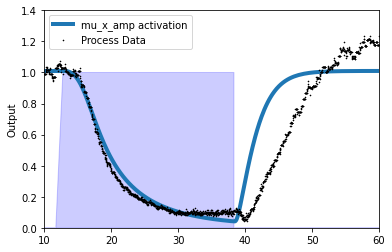

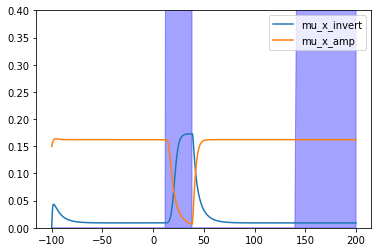

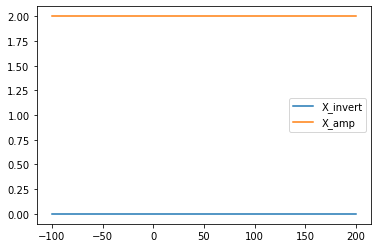

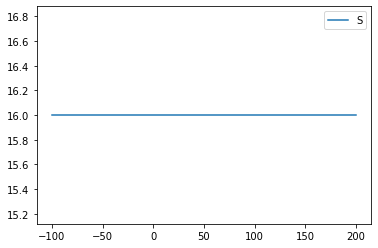

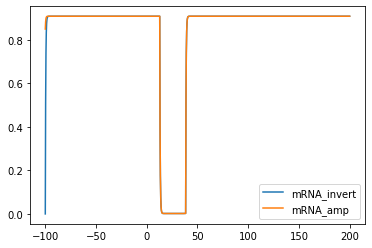

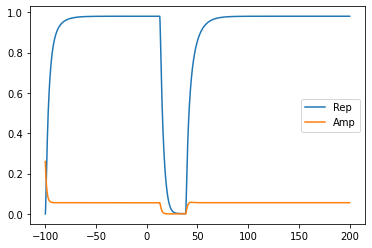

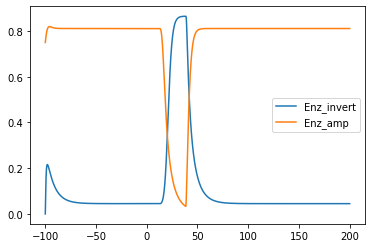

In [390]:
from scipy.interpolate import interp1d
import pandas as pd

# Dectivated at 12.7881 hrs
# Activated at 38.33806389 hrs

reactor_name = 'M5'

filename = '/home/smalani/Cybernetic/Germany Conference/training_data/Analyzed Data Oct 22.xlsx'
reactor_data = pd.read_excel(filename, sheet_name=reactor_name)

start_cutoff = 10
end_cutoff = 60
time_array_act = reactor_data['Time (hrs)'].values
opto_array_act = reactor_data['opt_gen_act_int'].values[np.logical_and(time_array_act > start_cutoff, time_array_act < end_cutoff)]
growth_rate_array_act = reactor_data['growth_rate'].values[np.logical_and(time_array_act > start_cutoff, time_array_act < end_cutoff)]
time_array_act = time_array_act[np.logical_and(time_array_act > start_cutoff, time_array_act < end_cutoff)] 

start_cutoff = 10
end_cutoff = 45
time_array_deact = reactor_data['Time (hrs)'].values
opto_array_deact = reactor_data['opt_gen_act_int'].values[np.logical_and(time_array_deact > start_cutoff, time_array_deact < end_cutoff)]
growth_rate_array_deact = reactor_data['growth_rate'].values[np.logical_and(time_array_deact > start_cutoff, time_array_deact < end_cutoff)]
time_array_deact = time_array_deact[np.logical_and(time_array_deact > start_cutoff, time_array_deact < end_cutoff)] + 48 - 12.7881

u_arr_int = [1, 0, 1]
t_span_arr = [-100, 12.7881, 38.33806389, 200]

u_arr_plot = [0, 1, 1, 0, 0, 1]
t_u_arr_plot = [0, 12.7881, 12.7881, 38.33806389, 38.33806389, 140]

u_interp = interp1d(t_u_arr_plot, u_arr_plot, kind='previous', fill_value='extrapolate')

od_sp = 2

optogrowth_p =  kdegR, ktrans_Rep, ktrans_Amp, ktrans_PDC, kdegP_Rep, kdegP_Amp, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

mRNA_invert_arr = []
mRNA_amp_arr = []
Rep_arr = []
Amp_arr = []
Enz_invert_arr = []
Enz_amp_arr = []
S_arr = []
X_invert_arr = []
X_amp_arr = []
t_arr = []


# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
x_init = [0, 1, 0, 0.25, 0, 0.8, 20, 0., 0.1]

x_init = [0, 0.85, 0, 0.26, 0., 0.75, 16, 0, 2]

for i, u in enumerate(u_arr_int):
    tspan = [t_span_arr[i]*60, t_span_arr[i+1]*60]

    period = 100 / 60
    Imax = 1

    setpoint = steady_mRNA_solve(u, period, Imax, x_guess=None)

    # print('my setpoint')
    # print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,od_sp),
                        rtol=1e-6, atol=1e-9, 
                        method='BDF',
                        first_step = 0.0001,
                        )
    x_init = sol.y[:,-1]

    # print(sol.status)
    # print(sol.message)
    # print(sol.success)

    mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y

    mRNA_invert_arr.append(mRNA_invert_x)
    mRNA_amp_arr.append(mRNA_amp_x)
    Rep_arr.append(Rep_x)
    Amp_arr.append(Amp_x)
    Enz_invert_arr.append(Enz_invert_x)
    Enz_amp_arr.append(Enz_amp_x)
    S_arr.append(S_x)
    X_invert_arr.append(X_invert_x)
    X_amp_arr.append(X_amp_x)
    t_arr.append(sol.t)

mRNA_invert = np.hstack(mRNA_invert_arr)
mRNA_amp = np.hstack(mRNA_amp_arr)
Rep = np.hstack(Rep_arr)
Amp = np.hstack(Amp_arr)
Enz_invert = np.hstack(Enz_invert_arr)
Enz_amp = np.hstack(Enz_amp_arr)
S = np.hstack(S_arr)
X_invert = np.hstack(X_invert_arr)
X_amp = np.hstack(X_amp_arr)
t_arr = np.hstack(t_arr)

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

plt.figure(facecolor='white')
mu_norm = np.average(mu_x_amp[np.where(np.logical_and(t_arr/60 > 10, t_arr/60 < 15))])
plt.plot(t_arr/60, mu_x_amp/mu_norm, label='mu_x_amp activation',linewidth=4)
mu_turb_norm = np.average(growth_rate_array_act[np.where(np.logical_and(time_array_act > 5, time_array_act < 12))])
plt.fill_between(t_arr/60, u_interp(t_arr/60), color='blue', alpha=0.2)
plt.ylabel('Output')
plt.legend(loc='best')
plt.plot(time_array_act,growth_rate_array_act/mu_turb_norm,'kx-',linewidth=0,label='Process Data', markersize=1)
plt.xlim([10, 60])
plt.ylim([0, 1.4])
plt.ylabel('Output')
plt.legend(loc='best')
plt.show()

plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
plt.fill_between(t_arr/60, u_interp(t_arr/60), color='blue', alpha=0.2)
plt.fill_between(t_arr/60, u_interp(t_arr/60), color='blue', alpha=0.2)
plt.ylim([0,0.4])
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, X_invert, label='X_invert')
plt.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, S, label='S')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Enz_invert, label='Enz_invert')
plt.plot(t_arr/60, Enz_amp, label='Enz_amp')
plt.legend()

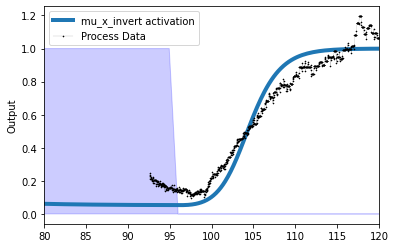

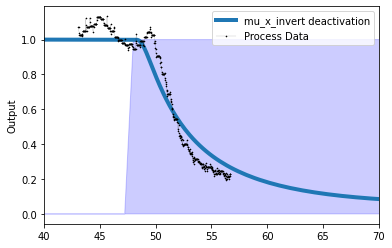

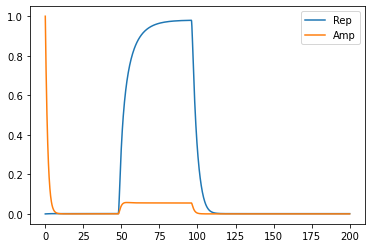

In [389]:
from scipy.interpolate import interp1d
import pandas as pd

# Dectivated at 12.7881 hrs
# Activated at 38.33806389 hrs

reactor_name = 'M7'

filename = '/home/smalani/Cybernetic/Germany Conference/training_data/Analyzed Data Oct 15.xlsx'
reactor_deact = pd.read_excel(filename, sheet_name=reactor_name)
filename = '/home/smalani/Cybernetic/Germany Conference/training_data/Analyzed Data Oct 17.xlsx'
reactor_act = pd.read_excel(filename, sheet_name=reactor_name)

act_cutoff = 5
time_array_act = reactor_act['Time (hrs)'].values
opto_array_act = reactor_act['opt_gen_act_int'].values[time_array_act > act_cutoff]
growth_rate_array_act = reactor_act['growth_rate'].values[time_array_act > act_cutoff]
time_array_act = time_array_act[time_array_act > act_cutoff]
time_array_act = time_array_act - time_array_act[(opto_array_act == 0).argmax()] + 96


deact_cutoff = 10
time_array_deact = reactor_deact['Time (hrs)'].values
opto_array_deact = reactor_deact['opt_gen_act_int'].values[time_array_deact > deact_cutoff]
growth_rate_array_deact = reactor_deact['growth_rate'].values[time_array_deact > deact_cutoff]
time_array_deact = time_array_deact[time_array_deact > deact_cutoff] 
time_array_deact = time_array_deact - time_array_deact[(opto_array_deact == 1).argmax()] + 48

u_arr_int = [0, 1, 0]
t_span_arr = [0, 48, 96, 200]

u_arr_plot = [0, 1, 1, 0, 0, 0]
t_u_arr_plot = [0, 48, 48, 96, 96, 140]

u_interp = interp1d(t_u_arr_plot, u_arr_plot, kind='previous', fill_value='extrapolate')

od_sp = 2

optogrowth_p =  kdegR, ktrans_Rep, ktrans_Amp, ktrans_PDC, kdegP_Rep, kdegP_Amp, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

mRNA_invert_arr = []
mRNA_amp_arr = []
Rep_arr = []
Amp_arr = []
Enz_invert_arr = []
Enz_amp_arr = []
S_arr = []
X_invert_arr = []
X_amp_arr = []
t_arr = []


# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
x_init = [0, 0, 0, 1, 0, 0, 20, 0.1, 0.]

for i, u in enumerate(u_arr_int):
    tspan = [t_span_arr[i]*60, t_span_arr[i+1]*60]

    period = 100 / 60
    Imax = 1

    setpoint = steady_mRNA_solve(u, period, Imax, x_guess=None)

    # print('my setpoint')
    # print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,od_sp),
                        rtol=1e-6, atol=1e-9, 
                        method='BDF',
                        first_step = 0.0001,
                        )
    x_init = sol.y[:,-1]

    # print(sol.status)
    # print(sol.message)
    # print(sol.success)

    mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y

    mRNA_invert_arr.append(mRNA_invert_x)
    mRNA_amp_arr.append(mRNA_amp_x)
    Rep_arr.append(Rep_x)
    Amp_arr.append(Amp_x)
    Enz_invert_arr.append(Enz_invert_x)
    Enz_amp_arr.append(Enz_amp_x)
    S_arr.append(S_x)
    X_invert_arr.append(X_invert_x)
    X_amp_arr.append(X_amp_x)
    t_arr.append(sol.t)

mRNA_invert = np.hstack(mRNA_invert_arr)
mRNA_amp = np.hstack(mRNA_amp_arr)
Rep = np.hstack(Rep_arr)
Amp = np.hstack(Amp_arr)
Enz_invert = np.hstack(Enz_invert_arr)
Enz_amp = np.hstack(Enz_amp_arr)
S = np.hstack(S_arr)
X_invert = np.hstack(X_invert_arr)
X_amp = np.hstack(X_amp_arr)
t_arr = np.hstack(t_arr)

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

plt.figure(facecolor='white')
mu_norm = np.average(mu_x_invert[np.where(np.logical_and(t_arr/60 > 40, t_arr/60 < 48))])
plt.plot(t_arr/60, mu_x_invert/mu_norm, label='mu_x_invert activation',linewidth=4)
mu_turb_norm = np.average(growth_rate_array_deact[np.where(np.logical_and(time_array_deact > 48, time_array_deact < 50))])
plt.plot(time_array_act,growth_rate_array_act/mu_turb_norm,'kx-',linewidth=0.1,label='Process Data', markersize=1)
plt.fill_between(t_arr/60, u_interp(t_arr/60), color='blue', alpha=0.2)
plt.xlim([80, 120])
plt.ylabel('Output')
plt.legend(loc='best')
plt.show()

plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert/mu_norm, label='mu_x_invert deactivation',linewidth=4)
plt.ylabel('Output')
plt.legend(loc='best')
plt.plot(time_array_deact,growth_rate_array_deact/mu_turb_norm,'kx-',linewidth=0.1,label='Process Data', markersize=1)
plt.fill_between(t_arr/60, u_interp(t_arr/60), color='blue', alpha=0.2)
plt.xlim([40, 70])
plt.ylabel('Output')
plt.legend(loc='best')
plt.show()

# plt.figure(facecolor='white')
# plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
# plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
# plt.fill_between(t_arr/60, u_interp(t_arr/60), color='blue', alpha=0.2)
# plt.legend()

# plt.figure(facecolor='white')
# plt.plot(t_arr/60, X_invert, label='X_invert')
# plt.plot(t_arr/60, X_amp, label='X_amp')
# plt.legend()

# plt.figure(facecolor='white')
# plt.plot(t_arr/60, S, label='S')
# plt.legend()


# plt.figure(facecolor='white')
# plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
# plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
# plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()

# plt.figure(facecolor='white')
# plt.plot(t_arr/60, Enz_invert, label='Enz_invert')
# plt.plot(t_arr/60, Enz_amp, label='Enz_amp')
# plt.legend()